# Neural Network Optimization -- Mean Field Regime

This notebook contains the example to perform NN optimization from a mean field view. In particular, our target is to reproduce a $m = 4$ neural network, where the optimal target density can be recognized as a mixture of delta function. We will show that as the $m$ increase, the NN is more powerful to approximate the optimal function. 

Besides, we will visualize the dynamics of $\theta$ from random to the near optimal one. And the effect of noisy gradient will be introduced.

## Setup

We define the optimal function in this part.

In [1]:
import torch
from torch import optim, nn
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# Fix the GPU you need.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Target particles (Optimal distribution)
M = torch.from_numpy(np.array([[2,0],[1,2],[2,1],[0,2]]).astype('float32'))
M2 = torch.from_numpy(np.array([[1/4,1/4,1/4,1/4]]).astype('float32'))
F = nn.Sequential(nn.Linear(2,4,bias = False),nn.Sigmoid(),nn.Linear(4,1,bias = False))
F[0].weight.data = M
F[2].weight.data = M2

F = F.cuda()

Fix random state here and initialize NN

In [40]:
SEED = 2020
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if you are using multi-GPU.
np.random.seed(SEED)  # Numpy module.
random.seed(SEED)  # Python random module.
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True



In [41]:
NN4_ = nn.Sequential(nn.Linear(2,4,bias = False),nn.Sigmoid(),nn.Linear(4,1,bias = False)).cuda()
torch.nn.init.normal_(NN4_[0].weight,mean=0.0, std=1.0)
torch.nn.init.normal_(NN4_[2].weight,mean=0.0, std=1.0)
NN8_ = nn.Sequential(nn.Linear(2,8,bias = False),nn.Sigmoid(),nn.Linear(8,1,bias = False)).cuda()
torch.nn.init.normal_(NN8_[0].weight,mean=0.0, std=1.0)
torch.nn.init.normal_(NN8_[2].weight,mean=0.0, std=1.0)
NN40_ = nn.Sequential(nn.Linear(2,40,bias = False),nn.Sigmoid(),nn.Linear(40,1,bias = False)).cuda()
torch.nn.init.normal_(NN40_[0].weight,mean=0.0, std=1.0)
torch.nn.init.normal_(NN40_[2].weight,mean=0.0, std=1.0)

Parameter containing:
tensor([[-1.9204, -0.1145, -0.4527, -1.2442,  1.8173, -0.2966, -1.2964,  0.2456,
          0.4652, -0.6506,  0.7172, -0.6462,  0.9609, -1.0553, -0.3281,  0.0106,
         -1.5839, -1.1855, -1.2155,  0.8996,  0.2063,  0.0940,  0.2209,  1.4169,
         -1.6955, -1.1991,  1.6927, -0.4963, -0.0071, -0.2158, -0.2294, -1.7772,
          0.7595, -1.0287, -1.1475, -0.6892,  0.5654, -0.1912, -0.7801, -0.1653]],
       device='cuda:0', requires_grad=True)

## Training stage

In [42]:
iterations = 10001
L0 = nn.MSELoss()
L = lambda o,F,model : L0(o,F)

# Large initial learning rate. 
# In fact, it is also possible to decay it after 10k iterations, 
# which makes error of NN40 less than 10^{-5}

op4_ = torch.optim.SGD(NN4_.parameters(),lr = 10)
op8_ = torch.optim.SGD(NN8_.parameters(),lr = 10)
op40_ = torch.optim.SGD(NN40_.parameters(),lr = 10)
NNs_ = [NN4_,NN8_,NN40_]
ops = [op4_,op8_,op40_]
loss_full = []

print('iter\tNN4\tNN8\tNN40')
for i in range(iterations):
    X_tr = torch.randn(10000,2).cuda()*100
    Fout = F(X_tr).detach()
    Fout_tr =  Fout+torch.randn_like(Fout)/10
    os = [NN4_(X_tr)/4,NN8_(X_tr)/8,NN40_(X_tr)/40]
    ls = []
    for j in range(3):
        ls.append(L(os[j],Fout_tr,NNs_[j]))
    
    for op in ops:
        op.zero_grad()

    for l in ls:
        l.backward()

    for op in ops:
        op.step()

    if i%100==0:
        loss_full.append([L0(o,Fout).item() for o in os])
        if (i)%1000==0:
            print(str(i)+'\t%.1e\t%.1e\t%.1e'%(loss_full[-1][0],loss_full[-1][1],loss_full[-1][2]))
    

iter	NN4	NN8	NN40
0	7.2e-01	6.1e-01	5.2e-01
1000	9.0e-03	2.5e-04	8.2e-05
2000	5.9e-03	1.4e-04	7.2e-05
3000	6.0e-03	2.3e-04	4.6e-05
4000	7.0e-03	6.5e-05	2.9e-05
5000	5.9e-03	5.1e-05	2.2e-05
6000	6.0e-03	8.0e-05	1.8e-05
7000	5.9e-03	6.6e-05	1.9e-05
8000	6.0e-03	1.7e-05	9.5e-06
9000	5.4e-03	8.5e-05	1.2e-05
10000	5.6e-03	7.6e-05	9.8e-06


Text(0, 0.5, 'loss (test)')

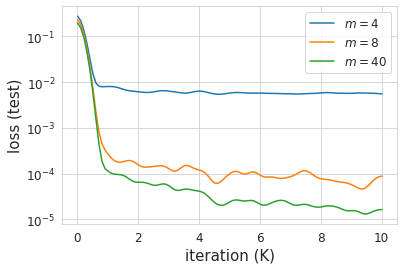

In [45]:
from scipy.ndimage.filters import gaussian_filter1d
import seaborn as sns
sns.set_style("whitegrid")
plt.plot(np.arange(101)/10+1/100,gaussian_filter1d(np.array(loss_full)[:,0],2),label = '$m=4$')
plt.plot(np.arange(101)/10+1/100,gaussian_filter1d(np.array(loss_full)[:,1],2),label = '$m=8$')
plt.plot(np.arange(101)/10+1/100,gaussian_filter1d(np.array(loss_full)[:,2],2),label = '$m=40$')
sns.set_style("whitegrid")
plt.yscale('log')
plt.legend()
plt.xlabel('iteration (K)',fontsize=15)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('loss (test)',fontsize=15)

## Visualization
Initialize a large NN to demonstrate the dynamics of $\theta$

Text(0.5, 1.0, 'initial particle $\\theta$ distribution')

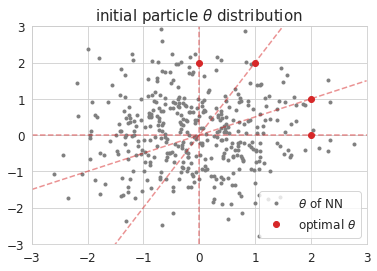

In [55]:
SEED = 2020
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if you are using multi-GPU.
np.random.seed(SEED)  # Numpy module.
random.seed(SEED)  # Python random module.
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
NN400_ = nn.Sequential(nn.Linear(2,400,bias = False),nn.Sigmoid(),nn.Linear(400,1,bias = False)).cuda()
torch.nn.init.normal_(NN400_[0].weight,mean=0.0, std=1.0)
torch.nn.init.normal_(NN400_[2].weight,mean=0.0, std=1.0)

wf = F[0].weight.data.cpu().numpy()
w400_ = NN400_[0].weight.data.cpu().numpy()

plt.plot(w400_[:,0],w400_[:,1],'C7.',label = r'$\theta$ of NN')
plt.plot(wf[:,0],wf[:,1],'C3o',label = r'optimal $\theta$')

xx = np.linspace(-3,3,100)
plt.plot(xx,np.zeros(xx.shape),'C3--',alpha = 0.5)
plt.plot(np.zeros(xx.shape),xx,'C3--',alpha = 0.5)
plt.plot(xx,xx*2,'C3--',alpha = 0.5)
plt.plot(xx,xx/2,'C3--',alpha = 0.5)

plt.xlim([-3,3])
plt.ylim([-3,3])
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title(r'initial particle $\theta$ distribution',fontsize=15)

### Training Process
Note that we have to add a regularization on u, otherwise it will not converge to optimal distribution ($u$ does not converge to a constant). 

Fang et al. (https://arxiv.org/pdf/1910.11508.pdf) has demonstrated that with $R(u)\gg R(\theta)$, we can obtain the near optimal representation.


In [56]:
iterations = 10000
reg_u = 1e-2
L0 = nn.MSELoss()
L = lambda o,F,model : L0(o,F)+reg_u*torch.norm(model[2].weight)**2/model[0].weight.shape[0]
op400_ = torch.optim.SGD(NN400_.parameters(),lr = 10)
NNs_ = [NN400_]
ops = [op400_]
loss_full = []
for i in range(iterations):
    X_tr = torch.randn(10000,2).cuda()*100
    Fout = F(X_tr).detach()
    Fout_tr =  Fout+torch.randn_like(Fout)/10
    
    os = [NN400_(X_tr)/400]
    ls = []
    for j in range(1):
        ls.append(L(os[j],Fout_tr,NNs_[j]))
    
    for op in ops:
        op.zero_grad()

    for l in ls:
        l.backward()

    for op in ops:
        op.step()


### Optimized particles 

Text(0.5, 1.0, 'optimized particle $\\theta$ distribution')

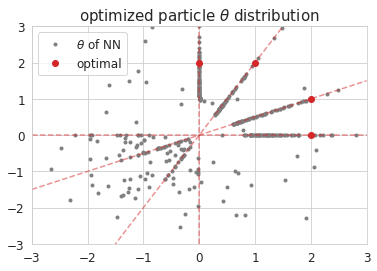

In [57]:
w400_ = NN400_[0].weight.data.cpu().numpy()
plt.plot(w400_[:,0],w400_[:,1],'C7.',label = r'$\theta$ of NN')
plt.plot(wf[:,0],wf[:,1],'C3o',label = 'optimal')

xx = np.linspace(-3,3,100)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.plot(xx,np.zeros(xx.shape),'C3--',alpha = 0.5)
plt.plot(np.zeros(xx.shape),xx,'C3--',alpha = 0.5)
plt.plot(xx,xx*2,'C3--',alpha = 0.5)
plt.plot(xx,xx/2,'C3--',alpha = 0.5)
plt.xlim([-3,3])
plt.ylim([-3,3])

plt.title(r'optimized particle $\theta$ distribution',fontsize=15)

### "wasted neurons"

Text(0.5, 1.0, 'histogram of $u$')

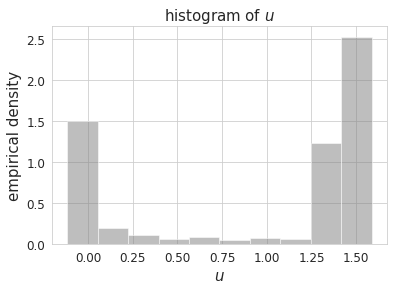

In [58]:

v400_ = NN400_[2].weight.data.cpu().numpy()
plt.hist(np.squeeze(v400_),density=1,alpha = 0.5,color='tab:gray',label = '$m=400$')
plt.xlabel('$u$',fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('empirical density',fontsize=15)
plt.title(r'histogram of $u$',fontsize=15)

### Important Neurons

Text(0.5, 1.0, 'optimized particle $\\theta$ with great importance ($u>1$)')

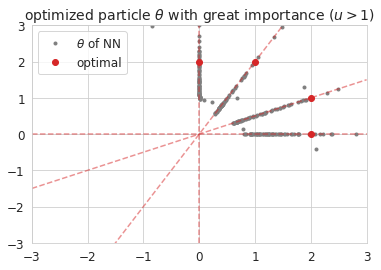

In [60]:
plt.plot(w400_[np.squeeze((v400_)>=1),0],w400_[np.squeeze((v400_)>=1),1],'C7.',label = r'$\theta$ of NN')

plt.plot(wf[:,0],wf[:,1],'C3o',label = 'optimal')


xx = np.linspace(-3,3,100)
plt.plot(xx,np.zeros(xx.shape),'C3--',alpha = 0.5)
plt.plot(np.zeros(xx.shape),xx,'C3--',alpha = 0.5)
plt.plot(xx,xx*2,'C3--',alpha = 0.5)
plt.plot(xx,xx/2,'C3--',alpha = 0.5)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title(r'optimized particle $\theta$ with great importance ($u>1$)',fontsize=14)

### Noisy gradient

In [61]:
SEED = 2020
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if you are using multi-GPU.
np.random.seed(SEED)  # Numpy module.
random.seed(SEED)  # Python random module.
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
NN400_ = nn.Sequential(nn.Linear(2,400,bias = False),nn.Sigmoid(),nn.Linear(400,1,bias = False)).cuda()
torch.nn.init.normal_(NN400_[0].weight,mean=0.0, std=1.0)
torch.nn.init.normal_(NN400_[2].weight,mean=0.0, std=1.0)

iterations = 10000

reg_u = 1e-2
reg_ent = 1e-2
L0 = nn.MSELoss()
L = lambda o,F,model : L0(o,F)+reg_u*torch.norm(model[2].weight)**2/model[0].weight.shape[0]
etas = [10]
op400_ = torch.optim.SGD(NN400_.parameters(),lr = 10)
NNs_ = [NN400_]
ops = [op400_]
for i in range(iterations):
    X_tr = torch.randn(10000,2).cuda()*100
    Fout = F(X_tr).detach()
    Fout_tr = Fout+torch.randn_like(Fout)/10
    os = [NN400_(X_tr)/400]
    ls = []
    for j in range(1):
        ls.append(L(os[j],Fout_tr,NNs_[j]))
    for op in ops:
        op.zero_grad()

    for l in ls:
        l.backward()
    for op in ops:
        op.step()
    for j,e in enumerate(etas):
        NNs_[j][0].weight.data = NNs_[j][0].weight.data + torch.randn_like(NNs_[j][0].weight.data) * reg_ent
        


Text(0.5, 1.0, 'optimized particle $\\theta$ distribution (noisy gradient)')

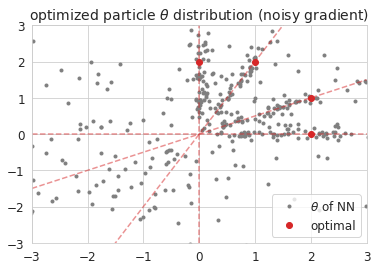

In [62]:
w400_ = NN400_[0].weight.data.cpu().numpy()

plt.plot(w400_[:,0],w400_[:,1],'C7.',label = r'$\theta$ of NN')


plt.plot(wf[:,0],wf[:,1],'C3o',label = 'optimal')

xx = np.linspace(-3,3,100)


plt.plot(xx,np.zeros(xx.shape),'C3--',alpha = 0.5)
plt.plot(np.zeros(xx.shape),xx,'C3--',alpha = 0.5)
plt.plot(xx,xx*2,'C3--',alpha = 0.5)
plt.plot(xx,xx/2,'C3--',alpha = 0.5)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'optimized particle $\theta$ distribution (noisy gradient)',fontsize=14)

Text(0.5, 1.0, 'histogram of $u$ (noisy)')

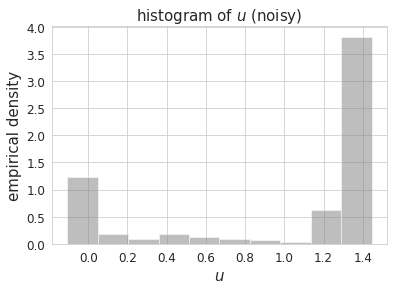

In [64]:
v400_ = NN400_[2].weight.data.cpu().numpy()
plt.hist(np.squeeze(v400_),density=1,alpha = 0.5,color='tab:gray',label = '$m=400$')
#plt.hist(np.squeeze(v40_),density=1,alpha = 0.5,color='tab:orange',label = '$m=40$')
plt.xlabel('$u$',fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend()
plt.ylabel('empirical density',fontsize=15)
plt.title(r'histogram of $u$ (noisy)',fontsize=15)

Text(0.5, 1.0, 'optimized particle $\\theta$ with great importance ($u>1$, noisy)')

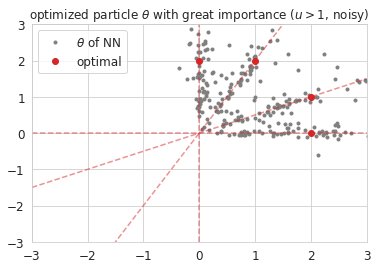

In [65]:
plt.plot(w400_[np.squeeze((v400_)>=1),0],w400_[np.squeeze((v400_)>=1),1],'C7.',label = r'$\theta$ of NN')
plt.plot(wf[:,0],wf[:,1],'C3o',label = 'optimal')

xx = np.linspace(-3,3,100)
plt.plot(xx,np.zeros(xx.shape),'C3--',alpha = 0.5)
plt.plot(np.zeros(xx.shape),xx,'C3--',alpha = 0.5)
plt.plot(xx,xx*2,'C3--',alpha = 0.5)
plt.plot(xx,xx/2,'C3--',alpha = 0.5)
plt.xlim([-3,3])
plt.ylim([-3,3])

plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title(r'optimized particle $\theta$ with great importance ($u>1$, noisy)')